<a href="https://colab.research.google.com/github/Akankshaaaa-01/Assignment-Submission-Portal/blob/main/Heart_Disease_Risk_Prediction1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install pyspark


In [18]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col
import pandas as pd


In [19]:
spark = SparkSession.builder.appName("HeartDiseasePrediction").getOrCreate()


In [20]:
data = spark.read.csv("/content/cardio_train.csv", header=True,sep=';', inferSchema=True)



In [21]:
# Create BMI and age_years columns
data = data.withColumn("BMI", col("weight") / ((col("height")/100) ** 2))
data = data.withColumn("age_years", (col("age") / 365).cast("int"))

# Now filter unrealistic values
data = data.filter(
    (col("ap_hi") > 50) & (col("ap_hi") < 250) &
    (col("ap_lo") > 30) & (col("ap_lo") < 180) &
    (col("weight") > 30) & (col("weight") < 200) &
    (col("height") > 100) & (col("height") < 220) &
    (col("BMI") > 10) & (col("BMI") < 60) &
    (col("age_years") > 18) & (col("age_years") < 100)
)



In [22]:
feature_cols = ["age_years", "height", "weight", "gender", "ap_hi", "ap_lo",
                "cholesterol", "gluc", "smoke", "alco", "active", "BMI"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
assembled = assembler.transform(data)

scaler = StandardScaler(inputCol="features_raw", outputCol="features")
scaler_model = scaler.fit(assembled)
scaled_data = scaler_model.transform(assembled)


In [23]:
train_data, test_data = scaled_data.randomSplit([0.7, 0.3], seed=41)


In [24]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Train models
lr_model = LogisticRegression(featuresCol="features", labelCol="cardio").fit(train_data)
rf_model = RandomForestClassifier(featuresCol="features", labelCol="cardio", numTrees=50).fit(train_data)

# Evaluate models
evaluator = BinaryClassificationEvaluator(labelCol="cardio")
lr_acc = evaluator.evaluate(lr_model.transform(test_data))
rf_acc = evaluator.evaluate(rf_model.transform(test_data))

print(f"Logistic Regression AUC: {lr_acc:.3f}")
print(f"Random Forest AUC: {rf_acc:.3f}")

Logistic Regression AUC: 0.791
Random Forest AUC: 0.789


In [31]:
from pyspark.sql.functions import col
feature_cols = ["age_years","height","weight","gender","ap_hi","ap_lo",
                "cholesterol","gluc","smoke","alco","active","BMI"]

user_features = [(55, 170, 75, 1, 130, 85, 2, 1, 0, 1, 1)]
user_df = spark.createDataFrame(user_features, feature_cols[:-1])
user_df = user_df.withColumn("BMI", col("weight") / ((col("height")/100) ** 2))


Predicted Probability of Cardiovascular Disease: 62.09%


In [32]:

user_assembled = assembler.transform(user_df)
user_scaled = scaler_model.transform(user_assembled)
chosen_model = lr_model if lr_acc > rf_acc else rf_model
user_prob = chosen_model.transform(user_scaled).select("probability").collect()[0][0][1]

print(f"Predicted Probability of Cardiovascular Disease: {user_prob:.2%}")

Predicted Probability of Cardiovascular Disease: 62.09%


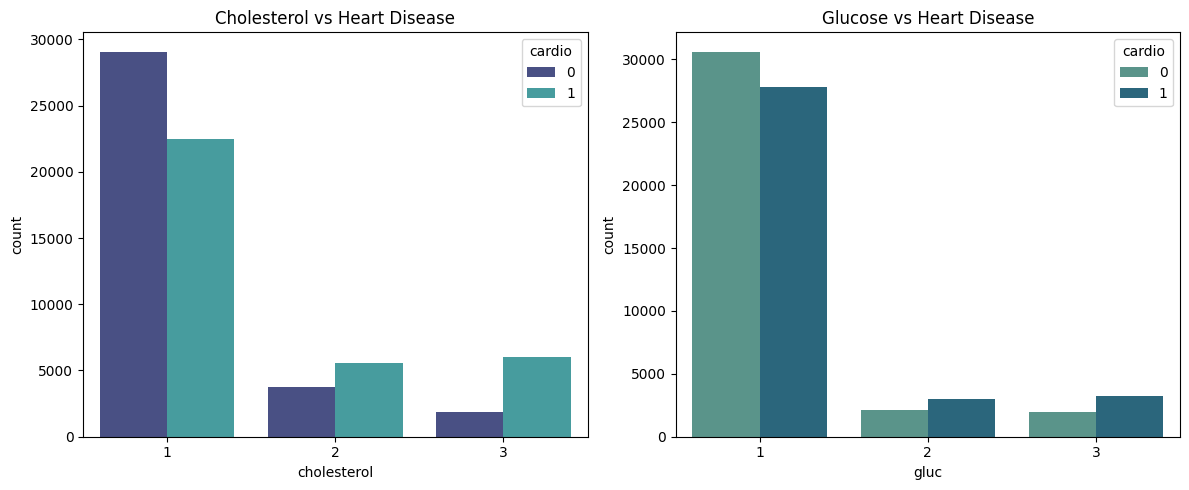

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert Spark DataFrame to Pandas for visualization
pdf = data.toPandas()

fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.countplot(x='cholesterol', hue='cardio', data=pdf, palette='mako', ax=axes[0])
axes[0].set_title("Cholesterol vs Heart Disease")

sns.countplot(x='gluc', hue='cardio', data=pdf, palette='crest', ax=axes[1])
axes[1].set_title("Glucose vs Heart Disease")

plt.tight_layout()
plt.show()



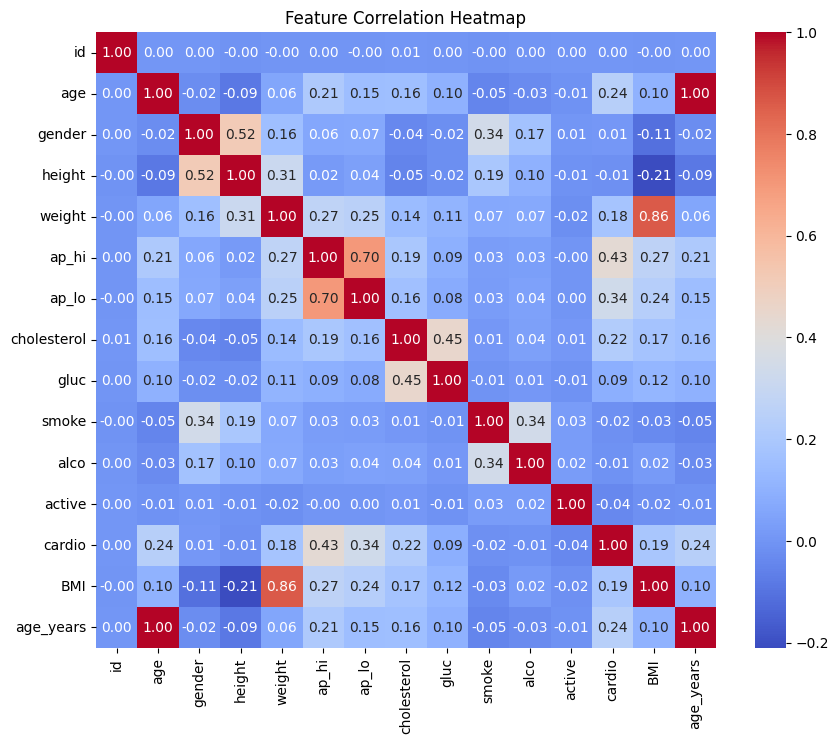

In [27]:
corr = pdf.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


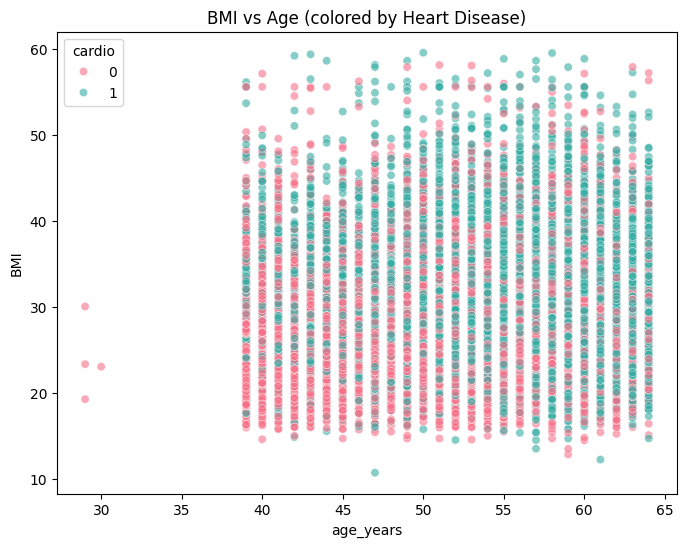

In [28]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='age_years', y='BMI', hue='cardio', data=pdf, alpha=0.6, palette='husl')
plt.title("BMI vs Age (colored by Heart Disease)")
plt.show()


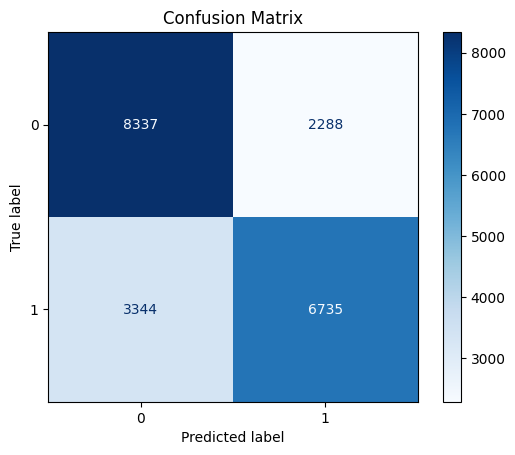

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert Spark predictions to Pandas
predictions = chosen_model.transform(test_data).select("cardio", "prediction").toPandas()

# Confusion Matrix
cm = confusion_matrix(predictions['cardio'], predictions['prediction'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
